# Sommaire

* [Chapitre 1 : Segmentation des données RFM](#chapter1)
    * [Standardisation des données](#section_1_1)
    * [K-means sur le jeu de données](#section_1_2)
    * [Classification ascendante hiérarchique](#section_1_3)
    * [Visualisation de la segmentation](#section_1_4)
    * [Représentation des clients types](#section_1_5)
        * [Préparation des radars](#section_1_5_1)
        * [1<sup>ère</sup> segmentation](#section_1_5_2)
        * [2<sup>ème</sup> segmentation](#section_1_5_3)
        * [3<sup>ème</sup> segmentation](#section_1_5_4)
        
* [Chapitre 2 : Segmentation des données numériques](#chapter2)
    * [K-means sur le jeu de données](#section_2_1)
    * [Classification ascendante hiérarchique](#section_2_1)
    * [Visualisation de la segmentation](#section_2_3)
    * [Représentation des clients types](#section_2_4)
        * [Préparation des radars](#section_2_4_1)
        * [1<sup>ère</sup> segmentation](#section_2_4_2)
        * [2<sup>ème</sup> segmentation](#section_2_4_3)
        * [3<sup>ème</sup> segmentation](#section_2_4_4)

* [Chapitre 3 : Segmentation de l'ensemble des données](#chapter3)
    * [K-means sur le jeu de données](#section_3_1)
    * [Classification ascendante hiérarchique](#section_3_1)
    * [Visualisation de la segmentation](#section_3_3)
    * [Sélection des variables](#section_3_4)
    * [Représentation des clients types](#section_3_5)
        * [Préparation des radars](#section_3_5_1)
        * [1<sup>ère</sup> segmentation](#section_3_5_2)
        * [2<sup>ème</sup> segmentation](#section_3_5_3)
        * [3<sup>ème</sup> segmentation](#section_3_5_4)

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Segmentation des données RFM
<a class="anchor" id="section_1_1"></a>
## Standardisation des données

Nous commencons notre étude sur la clusterisation par importer les librairies et les données nettoyées dans le notebook précédent.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import itertools
from itertools import chain
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection, preprocessing, metrics, manifold
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.collections import LineCollection
from matplotlib import colors
from matplotlib.lines import Line2D

data_olist = pd.read_csv("data_olist_after_pca_projet_5.csv", low_memory=False, index_col=0)

data_olist_raw = pd.read_csv("data_olist_raw_projet_5.csv", low_memory=False, index_col=0)

In [2]:
display(data_olist.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93341 entries, 0 to 93340
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            93341 non-null  object 
 1   order_purchase_timestamp      93341 non-null  object 
 2   recency                       93341 non-null  float64
 3   frequency                     93341 non-null  float64
 4   monetary                      93341 non-null  float64
 5   total_products                93341 non-null  float64
 6   nbr_category                  93341 non-null  float64
 7   nbr_payment                   93341 non-null  float64
 8   payment_installments          93341 non-null  float64
 9   heure                         93341 non-null  float64
 10  jour_semaine                  93341 non-null  float64
 11  jour                          93341 non-null  float64
 12  mois                          93341 non-null  float64
 13  a

None

Nous allons standardiser les données avec un RobustScaler car il y a beaucoup de variables avec des valeurs extrêmes.

In [3]:
X_rfm = data_olist.iloc[:,2:5].values

colonne_num = data_olist.iloc[:,2:18].columns
X_olist_num = data_olist[colonne_num].values

col_categ = data_olist.iloc[:,2:].columns
col_categ = col_categ.drop(["heure", "jour_semaine", "jour", "mois", "attente_commande", "retard_commande", 
                            "product_photos_qty", "vol_product"])

X_olist_categ = data_olist[col_categ].values

rob_scale = preprocessing.RobustScaler()

X_rfm_fit = rob_scale.fit_transform(X_rfm)

X_olist_num_fit = rob_scale.fit_transform(X_olist_num)

X_olist_fit = rob_scale.fit_transform(X_olist_categ)

<a class="anchor" id="section_1_2"></a>
## K-means sur le jeu de données

Nous allons effectuer un premier test de segmentation sur les données RFM. 

Dans un premier temps, nous allons déterminer différents scores (méthode du coude, score Davies-Bouldin, score Silhouette et score Calinski) pour chaque nombre de clusters choisis (entre 2 et 30). Nous représenterons l'ensemble des scores obtenus puis nous choisirons les nombres de centroïdes ayant obtenus les meilleurs scores. 

Dans un second temps, nous allons utiliser la méthode de classification hiérarchique ascendante pour 100 clusters afin d'établir le nombre de cluster idéal.

Dans un troisième temps, nous allons représenter les segmentations choisies. 

Enfin, nous allons représenter chaque client selon un radar et déterminer si des clients-types émergent ou non. 

In [209]:
inertia_olist_rfm = []
silhouettes_olist_rfm = []
davies_olist_rfm = []
calinski_olist_rfm = []
K_range_olist_rfm = range(2, 31)

for k in K_range_olist_rfm:
    model = KMeans(n_clusters=k, init = "k-means++").fit(X_rfm_fit)
    inertia_olist_rfm.append(model.inertia_)
    
    silh = metrics.silhouette_score(X_rfm_fit,model.labels_)
    silhouettes_olist_rfm.append(silh)
        
    dav = metrics.davies_bouldin_score(X_rfm_fit,model.labels_)
    davies_olist_rfm.append(dav)
    
    cali = metrics.calinski_harabasz_score(X_rfm_fit,model.labels_)
    calinski_olist_rfm.append(cali)
    
    if (k==5) | (k==15) | (k==25):
        print(k, round(silh,5), round(dav,5), round(cali,0))
    else:
        continue

5 0.34035 0.90292 65268.0
15 0.32056 0.84374 61017.0
25 0.32137 0.82576 59857.0


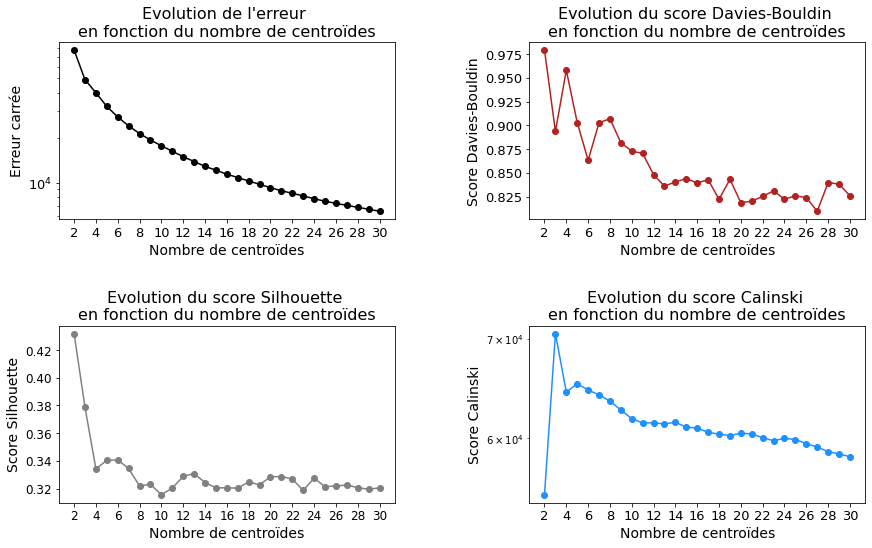

In [210]:
plt.figure(figsize=(14,8))

plt.subplot(221)
plt.plot(K_range_olist_rfm, inertia_olist_rfm, marker='o', color="black")

plt.xticks(K_range_olist_rfm[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.yscale("log")

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Erreur carrée", fontsize = 14)

plt.title("Evolution de l'erreur \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(222)

plt.plot(K_range_olist_rfm, davies_olist_rfm, marker='o', color="firebrick")

plt.xticks(K_range_olist_rfm[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Davies-Bouldin", fontsize = 14)

plt.title("Evolution du score Davies-Bouldin \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(223)

plt.plot(K_range_olist_rfm, silhouettes_olist_rfm, marker='o', color="gray")

plt.xticks(K_range_olist_rfm[::2], fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Silhouette", fontsize = 14)

plt.title("Evolution du score Silhouette \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(224)

plt.plot(K_range_olist_rfm, calinski_olist_rfm, marker='o', color="dodgerblue")

plt.yscale("log")

plt.xticks(K_range_olist_rfm[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Calinski", fontsize = 14)

plt.title("Evolution du score Calinski \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
plt.show()

<a class="anchor" id="section_1_3"></a>
## Classification ascendante hierarchique

En nous basant sur le k-means, nous allons créer 100 clusters qui seront utilisés pour la classification ascendante hierarchique (CAH). Le fait de créer 100 clusters permet une meilleure visualisation de la classification mais aussi d'éviter les problèmes de mémoire.

In [7]:
model_100 = KMeans(n_clusters=100, init = "k-means++")
model_100.fit(X_rfm_fit)

data_cluster_rfm_100 = pd.DataFrame(model_100.cluster_centers_)

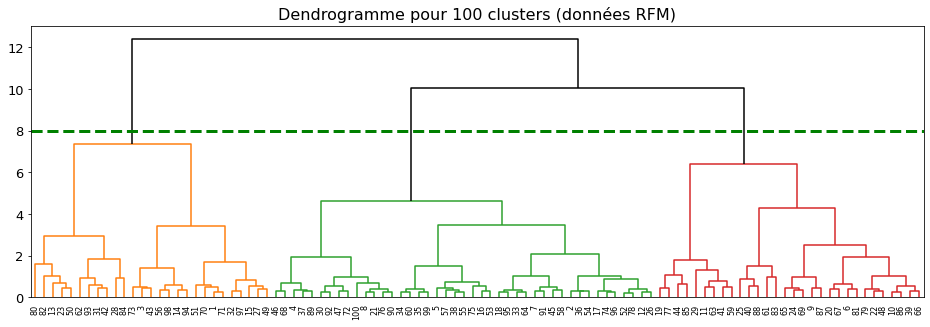

In [9]:
linkage_data = linkage(model_100.cluster_centers_, method='ward', metric='euclidean')
labels_str = [str(i) for i in np.arange(1,101,1)]

plt.figure(figsize=(16, 5))

dendrogram(linkage_data, labels = labels_str, orientation = "top", color_threshold = 8, above_threshold_color = 'black')

plt.axhline(y = 8, ls="dashed", linewidth=3, c = "green")

plt.xticks(fontsize=8)
plt.yticks(fontsize=13)

plt.title("Dendrogramme pour 100 clusters (données RFM)", fontsize=16)

plt.show()

<a class="anchor" id="section_1_4"></a>
## Visualisation de la segmentation

En nous basant sur les scores plus haut, nous choisissons de représenter les données selon 3 clusters, 6 clusters et 13 clusters.

Nous allons visualiser la segmentation en représentant les variables deux à deux et après avoir fait un t-SNE. 

In [7]:
model_3 = KMeans(n_clusters=3, init = "k-means++")
model_3.fit(X_rfm_fit)

model_6 = KMeans(n_clusters=6, init = "k-means++")
model_6.fit(X_rfm_fit)

model_13 = KMeans(n_clusters=13, init = "k-means++")
model_13.fit(X_rfm_fit)

KMeans(n_clusters=13)

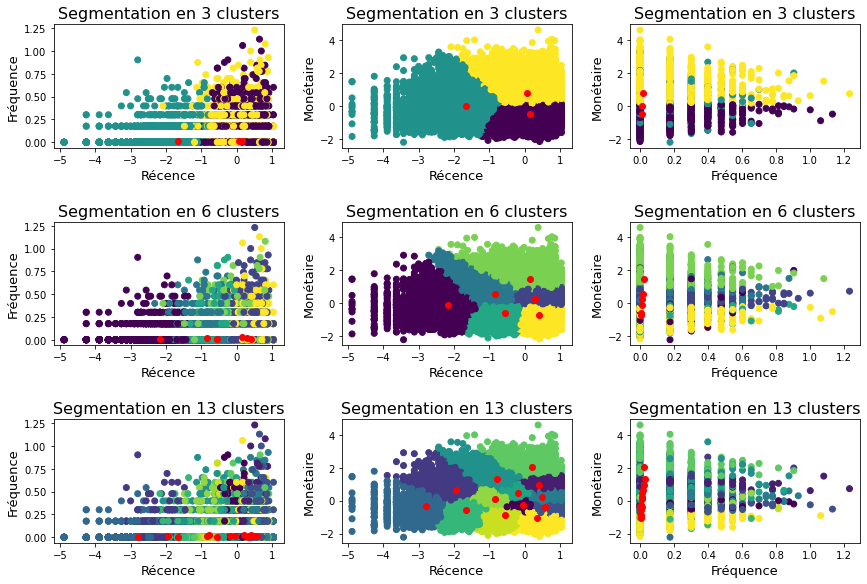

In [85]:
plt.figure(figsize=(14,9))
col = ["Récence", "Fréquence", "Monétaire"]

k = 0
for i in range (0,2):
    for j in range (i+1,3):
        k += 1
        plt.subplot(3,3,k)
        plt.scatter(X_rfm_fit[:,i], X_rfm_fit[:,j], c = model_3.predict(X_rfm_fit))
        plt.scatter(model_3.cluster_centers_[:,i], model_3.cluster_centers_[:,j], color = "red")
        plt.xlabel(f"{col[i]}", fontsize=13)
        plt.ylabel(f"{col[j]}", fontsize=13)
        plt.title("Segmentation en 3 clusters", fontsize=16)
        
for i in range (0,2):
    for j in range (i+1,3):
        k += 1
        plt.subplot(3,3,k)
        plt.scatter(X_rfm_fit[:,i], X_rfm_fit[:,j], c = model_6.predict(X_rfm_fit))
        plt.scatter(model_6.cluster_centers_[:,i], model_6.cluster_centers_[:,j], color = "red")
        plt.xlabel(f"{col[i]}", fontsize=13)
        plt.ylabel(f"{col[j]}", fontsize=13)
        plt.title("Segmentation en 6 clusters", fontsize=16)
        
for i in range (0,2):
    for j in range (i+1,3):
        k += 1
        plt.subplot(3,3,k)
        plt.scatter(X_rfm_fit[:,i], X_rfm_fit[:,j], c = model_13.predict(X_rfm_fit))
        plt.scatter(model_13.cluster_centers_[:,i], model_13.cluster_centers_[:,j], color = "red")
        plt.xlabel(f"{col[i]}", fontsize=13)
        plt.ylabel(f"{col[j]}", fontsize=13)
        plt.title("Segmentation en 13 clusters", fontsize=16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.6)

plt.show()

In [28]:
tsne = manifold.TSNE(n_components=2, perplexity=60, learning_rate="auto", random_state = 0)

X_rfm_tsne = tsne.fit_transform(X_rfm_fit)

C:\Users\farid\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


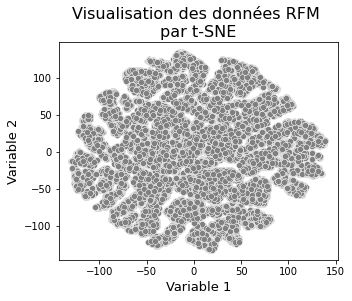

In [63]:
plt.figure(figsize=(5,4))
sns.scatterplot(x = X_rfm_tsne[:,0], y = X_rfm_tsne[:,1], color="gray")

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données RFM \npar t-SNE", fontsize=16)

plt.show()

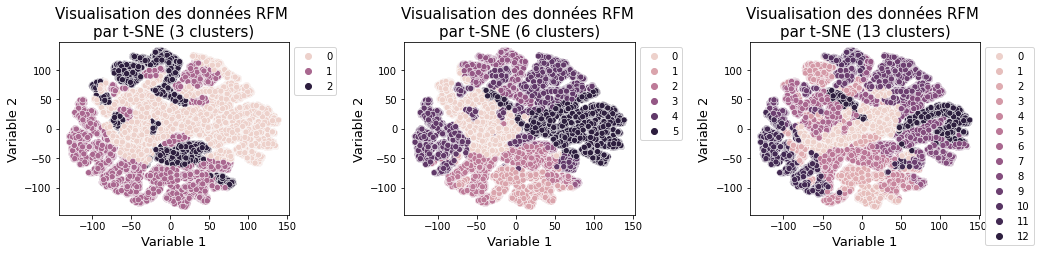

In [145]:
plt.figure(figsize=(16,3))
plt.subplot(131)
sns.scatterplot(x = X_rfm_tsne[:,0], 
                y = X_rfm_tsne[:,1],
                hue = model_3.predict(X_rfm_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données RFM \npar t-SNE (3 clusters)", fontsize=15)

plt.legend(bbox_to_anchor=(1,1))

plt.subplot(132)
sns.scatterplot(x = X_rfm_tsne[:,0], 
                y = X_rfm_tsne[:,1],
                hue = model_6.predict(X_rfm_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données RFM \npar t-SNE (6 clusters)", fontsize=15)

plt.legend(bbox_to_anchor=(1,1))

plt.subplot(133)
sns.scatterplot(x = X_rfm_tsne[:,0], 
                y = X_rfm_tsne[:,1],
                hue = model_13.predict(X_rfm_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données RFM \npar t-SNE (13 clusters)", fontsize=15)

plt.legend(bbox_to_anchor=(1,1))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)
plt.show()

Avec les 2 visualisations montrées plus haut, nous voyons qu'il n'y a pas de segmentation visuelle. 

<a class="anchor" id="section_1_5"></a>
## Représentation des clients types

Maintenant que nous venons de sélectionner les clusters les plus pertinents, nous allons représenter chaque client type sur un radar, ce qui permettra de faire ressortir les points forts et les points faibles des clients et de les identifier.

Si cette identification n'est pas possible, nous passerons à l'étude des données numériques, puis à l'étude des données catégorielles.

<a class="anchor" id="section_1_5_1"></a>
### Préparation des radars

Nous commencons par associer chaque client au label qui lui est propre pour chaque segmentation. Ensuite, nous créeons 3 dataframes pour chaque segmentation et nous groupons (en faisant la moyenne) les données pour chaque segmentation selon chaque label. Enfin nous appliquons une normalisation entre 0 et 10 de telle sorte à déterminer les forces et faiblesses des clients. 

In [29]:
data_olist["cluster_rfm_3"] = pd.Series(model_3.labels_)
data_olist["cluster_rfm_6"] = pd.Series(model_6.labels_)
data_olist["cluster_rfm_13"] = pd.Series(model_13.labels_)

pourcentage_rfm_3 = ((data_olist["cluster_rfm_3"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_rfm_6 = ((data_olist["cluster_rfm_6"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_rfm_13 = ((data_olist["cluster_rfm_13"].value_counts(normalize=True).sort_index())*100).round(1)

In [30]:
col_rfm_3 = ["recency", "frequency", 'monetary',
             "cluster_rfm_3"]

col_rfm_6 = ["recency", "frequency", 'monetary',
             "cluster_rfm_6"]

col_rfm_13 = ["recency", "frequency", 'monetary',
              "cluster_rfm_13"
                ]

col_rfm_simple = ["Recency", "Frequency", 'Monetary']

In [31]:
cluster_rfm_client_3 = data_olist[col_rfm_3].groupby("cluster_rfm_3").mean()
cluster_rfm_client_6 = data_olist[col_rfm_6].groupby("cluster_rfm_6").mean()
cluster_rfm_client_13 = data_olist[col_rfm_13].groupby("cluster_rfm_13").mean()

In [32]:
scaler = MinMaxScaler(feature_range=(0, 10))

cluster_rfm_3 = pd.DataFrame(scaler.fit_transform(cluster_rfm_client_3), 
                         columns = cluster_rfm_client_3.columns)

cluster_rfm_6 = pd.DataFrame(scaler.fit_transform(cluster_rfm_client_6), 
                         columns = cluster_rfm_client_6.columns)

cluster_rfm_13 = pd.DataFrame(scaler.fit_transform(cluster_rfm_client_13), 
                         columns = cluster_rfm_client_13.columns)

<a class="anchor" id="section_1_5_2"></a>
### 1<sup>ère</sup> segmentation

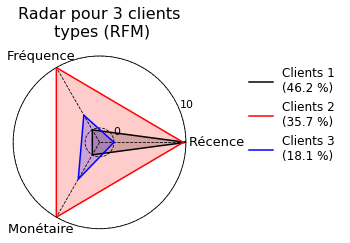

In [147]:
categories = ["        Récence", "Fréquence    ", "Monétaire    "]

client_1 = cluster_rfm_3.iloc[0,:].values.tolist()
client_2 = cluster_rfm_3.iloc[1,:].values.tolist()
client_3 = cluster_rfm_3.iloc[2,:].values.tolist()

client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])


liste_client = [client_1, client_2, client_3]
colors = ["black", "red", "blue", "green"]

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(3, 3))
plt.subplot(polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_rfm_3[0]} %)", color = "black")
plt.fill(angles, client_1, "black", alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_rfm_3[1]} %)", color = "red")
plt.fill(angles, client_2, "red", alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_rfm_3[2]} %)", color = "blue")
plt.fill(angles, client_3, "blue", alpha=0.2)
    
    
lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)
plt.grid(visible=True, color="black", linestyle="dashed")
    
plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("Radar pour 3 clients\n types (RFM)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 12)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)
plt.show()

<a class="anchor" id="section_1_5_3"></a>
### 2<sup>ème</sup> segmentation

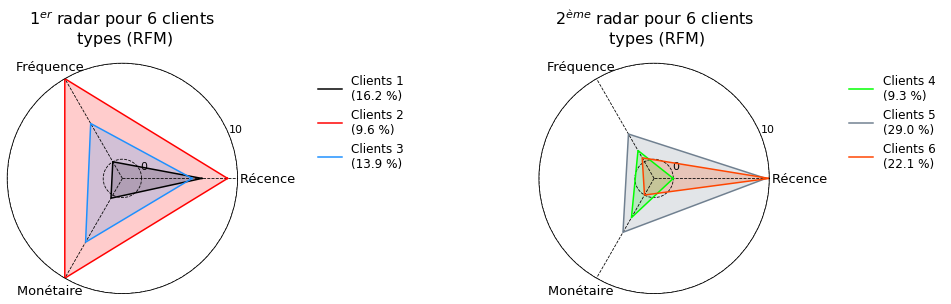

In [148]:
client_1 = cluster_rfm_6.iloc[0,:].values.tolist()
client_2 = cluster_rfm_6.iloc[1,:].values.tolist()
client_3 = cluster_rfm_6.iloc[2,:].values.tolist()
client_4 = cluster_rfm_6.iloc[3,:].values.tolist()
client_5 = cluster_rfm_6.iloc[4,:].values.tolist()
client_6 = cluster_rfm_6.iloc[5,:].values.tolist()

client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])
client_5.append(client_5[0])
client_6.append(client_6[0])


label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(15, 4))
plt.subplot(121, polar=True)


plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_rfm_6[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_rfm_6[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_rfm_6[2]} %)", color="dodgerblue")
plt.fill(angles, client_3, "dodgerblue",alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$1^{er}$ radar pour 6 clients\n types (RFM)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 12)

plt.subplot(122, polar=True)

plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_rfm_6[3]} %)", color="lime")
plt.fill(angles, client_4, "lime",alpha=0.2)

plt.plot(label_loc, client_5, label = f"Clients 5 \n({pourcentage_rfm_6[4]} %)", color="slategray")
plt.fill(angles, client_5, 'slategray', alpha=0.2)

plt.plot(label_loc, client_6, label = f"Clients 6 \n({pourcentage_rfm_6[5]} %)", color="orangered")
plt.fill(angles, client_6, "orangered",alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)

plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$2^{ème}$ radar pour 6 clients\n types (RFM)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 12)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

<a class="anchor" id="section_1_5_4"></a>
### 3<sup>ème</sup> segmentation

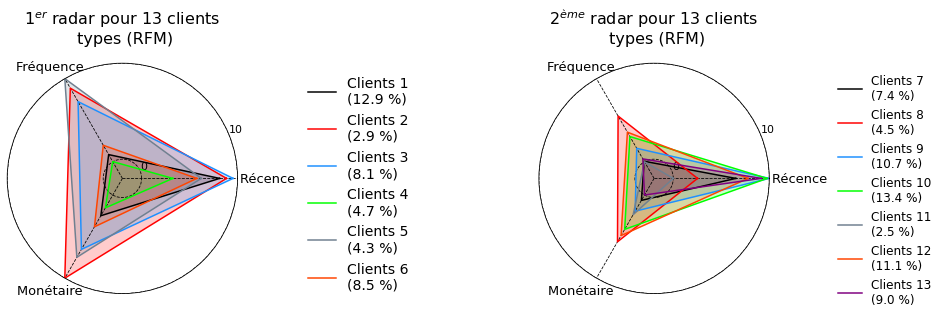

In [149]:
client_1 = cluster_rfm_13.iloc[0,:].values.tolist()
client_2 = cluster_rfm_13.iloc[1,:].values.tolist()
client_3 = cluster_rfm_13.iloc[2,:].values.tolist()
client_4 = cluster_rfm_13.iloc[3,:].values.tolist()
client_5 = cluster_rfm_13.iloc[4,:].values.tolist()
client_6 = cluster_rfm_13.iloc[5,:].values.tolist()
client_7 = cluster_rfm_13.iloc[6,:].values.tolist()
client_8 = cluster_rfm_13.iloc[7,:].values.tolist()
client_9 = cluster_rfm_13.iloc[8,:].values.tolist()
client_10 = cluster_rfm_13.iloc[9,:].values.tolist()
client_11 = cluster_rfm_13.iloc[10,:].values.tolist()
client_12 = cluster_rfm_13.iloc[11,:].values.tolist()
client_13 = cluster_rfm_13.iloc[12,:].values.tolist()

client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])
client_5.append(client_5[0])
client_6.append(client_6[0])
client_7.append(client_7[0])
client_8.append(client_8[0])
client_9.append(client_9[0])
client_10.append(client_10[0])
client_11.append(client_11[0])
client_12.append(client_12[0])
client_13.append(client_13[0])

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(15, 4))
plt.subplot(121, polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_rfm_13[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_rfm_13[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_rfm_13[2]} %)", color="dodgerblue")
plt.fill(angles, client_3, "dodgerblue",alpha=0.2)

plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_rfm_13[3]} %)", color="lime")
plt.fill(angles, client_4, "lime",alpha=0.2)

plt.plot(label_loc, client_5, label = f"Clients 5 \n({pourcentage_rfm_13[4]} %)", color="slategray")
plt.fill(angles, client_5, 'slategray', alpha=0.2)

plt.plot(label_loc, client_6, label = f"Clients 6 \n({pourcentage_rfm_13[5]} %)", color="orangered")
plt.fill(angles, client_6, "orangered",alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$1^{er}$ radar pour 13 clients\n types (RFM)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.25, 1),frameon=False, fontsize = 14)

plt.subplot(122, polar=True)

plt.plot(label_loc, client_7, label = f"Clients 7 \n({pourcentage_rfm_13[6]} %)", color="black")
plt.fill(angles, client_7, "black",alpha=0.2)

plt.plot(label_loc, client_8, label = f"Clients 8 \n({pourcentage_rfm_13[7]} %)", color="red")
plt.fill(angles, client_8, 'red', alpha=0.2)

plt.plot(label_loc, client_9, label = f"Clients 9 \n({pourcentage_rfm_13[8]} %)", color="dodgerblue")
plt.fill(angles, client_9, "dodgerblue",alpha=0.2)

plt.plot(label_loc, client_10, label = f"Clients 10 \n({pourcentage_rfm_13[9]} %)", color="lime")
plt.fill(angles, client_10, "lime",alpha=0.2)

plt.plot(label_loc, client_11, label = f"Clients 11 \n({pourcentage_rfm_13[10]} %)", color="slategray")
plt.fill(angles, client_11, 'slategray', alpha=0.2)

plt.plot(label_loc, client_12, label = f"Clients 12 \n({pourcentage_rfm_13[11]} %)", color="orangered")
plt.fill(angles, client_12, "orangered",alpha=0.2)

plt.plot(label_loc, client_13, label = f"Clients 13 \n({pourcentage_rfm_13[12]} %)", color="purple")
plt.fill(angles, client_13, "purple",alpha=0.2)


lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)

plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$2^{ème}$ radar pour 13 clients\n types (RFM)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.25, 1),frameon=False, fontsize = 12)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

Nous pouvons voir que pour les différents clusters choisis, il n'y a pas de segmentation visible sur l'ensemble des données RFM.
De plus, pour chaque segmentation, il n'y a pas de client-types visibles dans la mesure où les variables RFM ne sont pas assez suffisantes pour décrire un client.

Nous allons poursuivre notre étude avec les données numériques.
<a class="anchor" id="chapter2"></a>
# Chapitre 2 : Segmentation des données numériques
<a class="anchor" id="section_2_1"></a>
## K-means sur le jeu de données

In [143]:
inertia_olist_num = []
silhouettes_olist_num = []
davies_olist_num = []
calinski_olist_num = []
K_range_olist_num = range(2, 31)

for k in K_range_olist_num:
    model = KMeans(n_clusters=k, init = "k-means++").fit(X_olist_num_fit)
    inertia_olist_num.append(model.inertia_)
    
    silh = metrics.silhouette_score(X_olist_num_fit,model.labels_)
    silhouettes_olist_num.append(silh)
    
    dav = metrics.davies_bouldin_score(X_olist_num_fit,model.labels_)
    davies_olist_num.append(dav)
    
    cali = metrics.calinski_harabasz_score(X_olist_num_fit,model.labels_)
    calinski_olist_num.append(cali)
    
    if (k==5) | (k==15) | (k==25):
        print(k, round(silh,5), round(dav,5), round(cali,0))
    else:
        continue

5 0.14488 1.84118 16706.0
15 0.0983 1.9165 8785.0
25 0.08144 2.04857 6200.0


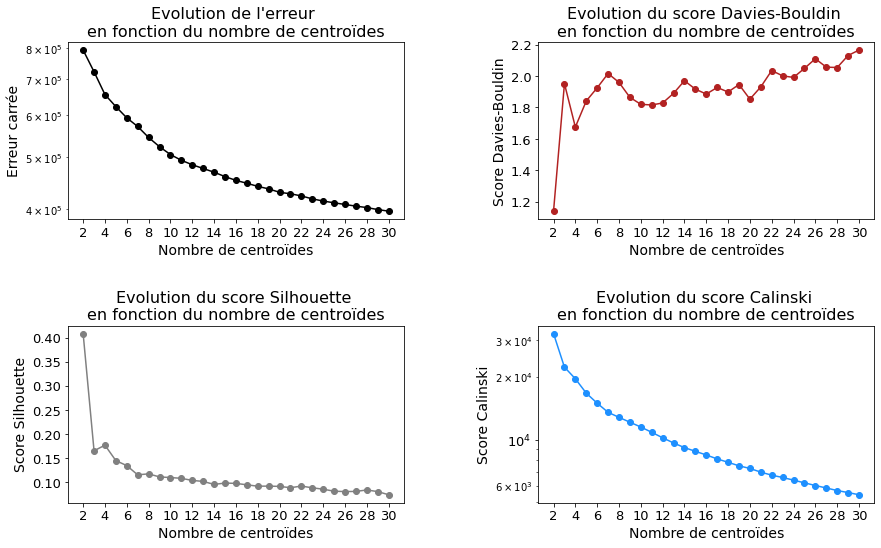

In [144]:
plt.figure(figsize=(14,8))
plt.subplot(221)
plt.plot(K_range_olist_num, inertia_olist_num, marker='o', color="black")

plt.xticks(K_range_olist_num[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.yscale("log")

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Erreur carrée", fontsize = 14)

plt.title("Evolution de l'erreur \nen fonction du nombre de centroïdes", fontsize = 16)


plt.subplot(222)
plt.plot(K_range_olist_num, davies_olist_num, marker='o', color="firebrick")

plt.xticks(K_range_olist_num[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Davies-Bouldin", fontsize = 14)

plt.title("Evolution du score Davies-Bouldin \nen fonction du nombre de centroïdes", fontsize = 16)


plt.subplot(223)

plt.plot(K_range_olist_num, silhouettes_olist_num, marker='o', color="gray")

plt.xticks(K_range_olist_num[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Silhouette", fontsize = 14)

plt.title("Evolution du score Silhouette \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(224)

plt.plot(K_range_olist_num, calinski_olist_num, marker='o', color="dodgerblue")

plt.yscale("log")

plt.xticks(K_range_olist_num[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Calinski", fontsize = 14)

plt.title("Evolution du score Calinski \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
plt.show()

<a class="anchor" id="section_2_2"></a>
## Classification ascendante hierarchique

In [150]:
model_num_100 = KMeans(n_clusters = 100, init = "k-means++")
model_num_100.fit(X_olist_num_fit)

data_cluster_num = model_num_100.cluster_centers_

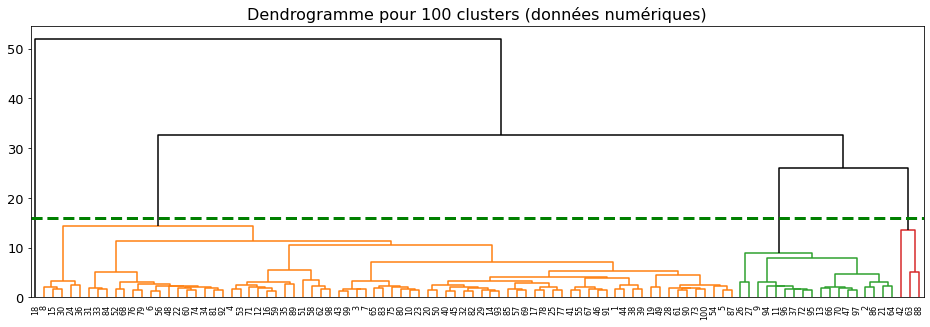

In [153]:
linkage_data_num = linkage(data_cluster_num, method='ward', metric='euclidean')
labels_str = [str(i) for i in np.arange(1,101,1)]

plt.figure(figsize=(16, 5))

dendrogram(linkage_data_num, labels = labels_str, orientation = "top", color_threshold = 16, above_threshold_color = 'black')

plt.axhline(y = 16, ls="dashed", linewidth=3, c = "green")

plt.xticks(fontsize=8)
plt.yticks(fontsize=13)

plt.title("Dendrogramme pour 100 clusters (données numériques)", fontsize=16)

plt.show()

<a class="anchor" id="section_2_3"></a>
## Visualisation de la segmentation

En nous basant sur les scores, nous choisissons de segmenter les données en 3 clusters, 4 clusters et 10 clusters. 

Comme précédemment, nous allons visualiser la segmentation à travers les données brut (en choisissant 2 variables du jeu de données) et via une visualisation t-SNE.

In [9]:
model_num_3 = KMeans(n_clusters = 3, init = "k-means++")
model_num_3.fit(X_olist_num_fit)

model_num_4 = KMeans(n_clusters = 4, init = "k-means++")
model_num_4.fit(X_olist_num_fit)

model_num_11 = KMeans(n_clusters = 11, init = "k-means++")
model_num_11.fit(X_olist_num_fit)

KMeans(n_clusters=11)

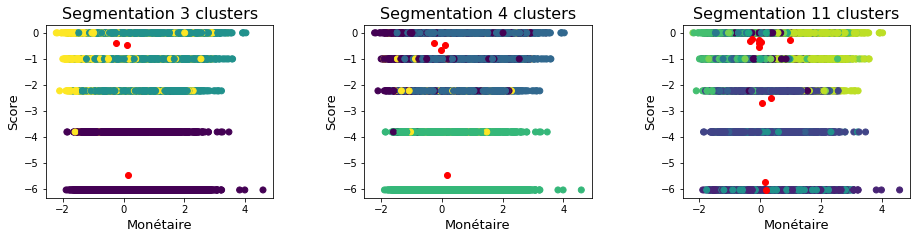

In [55]:
plt.figure(figsize=(15,3))
colonne_num = ['Récence', 'Fréquence', 'Monétaire', "Nbr d'articles", 'Nbr categorie',
               'Nbr paiement', 'Nbre versement', 'Heure', 'Jour semaine', 'Jour (mois)',
               'Mois', 'Attente commande', 'Retard commande',
               'Distance vendeur/client', 'Nbr photos', 'Score']

plt.subplot(1,3,1)

plt.scatter(X_olist_num_fit[:,2], X_olist_num_fit[:,-1], c=model_num_3.predict(X_olist_num_fit))
plt.scatter(model_num_3.cluster_centers_[:,2], model_num_3.cluster_centers_[:,-1], color = "red")
    
plt.xlabel(f"{colonne_num[2]}", fontsize=13)
plt.ylabel(f"{colonne_num[-1]}", fontsize=13)
    
plt.title("Segmentation 3 clusters", fontsize = 16)
    
plt.subplot(1,3,2)

plt.scatter(X_olist_num_fit[:,2], X_olist_num_fit[:,-1], c=model_num_4.predict(X_olist_num_fit))
plt.scatter(model_num_4.cluster_centers_[:,2], model_num_4.cluster_centers_[:,-1], color = "red")
    
plt.xlabel(f"{colonne_num[2]}", fontsize=13)
plt.ylabel(f"{colonne_num[-1]}", fontsize=13)
    
plt.title("Segmentation 4 clusters", fontsize = 16)

plt.subplot(1,3,3)

plt.scatter(X_olist_num_fit[:,2], X_olist_num_fit[:,-1], c=model_num_11.predict(X_olist_num_fit))
plt.scatter(model_num_11.cluster_centers_[:,2], model_num_11.cluster_centers_[:,-1], color = "red")
    
plt.xlabel(f"{colonne_num[2]}", fontsize=13)
plt.ylabel(f"{colonne_num[-1]}", fontsize=13)
    
plt.title("Segmentation 11 clusters", fontsize = 16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
plt.show()

In [5]:
X_num_tsne = tsne.fit_transform(X_olist_num_fit)

C:\Users\farid\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


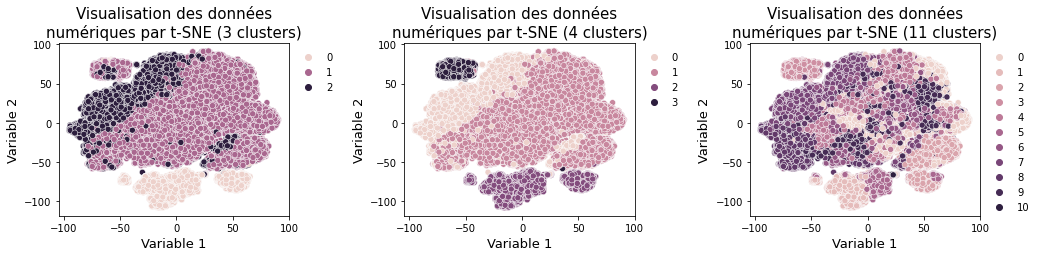

In [154]:
plt.figure(figsize=(16,3))
plt.subplot(131)
sns.scatterplot(x = X_num_tsne[:,0], 
                y = X_num_tsne[:,1],
                hue = model_num_3.predict(X_olist_num_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données\nnumériques par t-SNE (3 clusters)", fontsize=15)

plt.legend(frameon = False, bbox_to_anchor=(1,1))

plt.subplot(132)
sns.scatterplot(x = X_num_tsne[:,0], 
                y = X_num_tsne[:,1],
                hue = model_num_4.predict(X_olist_num_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données\nnumériques par t-SNE (4 clusters)", fontsize=15)

plt.legend(frameon = False, bbox_to_anchor=(1,1))

plt.subplot(133)

sns.scatterplot(x = X_num_tsne[:,0], 
                y = X_num_tsne[:,1],
                hue = model_num_11.predict(X_olist_num_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données\nnumériques par t-SNE (11 clusters)", fontsize=15)

plt.legend(frameon = False, bbox_to_anchor=(1,1))


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)
plt.show()

Avec les 2 visualisations montrées plus haut, nous voyons que la segmentation n'est pas visuellement idéale dans la mesure où il y a recouvrement entre les différents groupes de points de clusters différents. 

<a class="anchor" id="section_2_4"></a>
## Représentation des clients types

Comme précedemment, nous allons représenter chaque client via un radar et essayer d'identifier des client types.

Si cette identification n'est pas possible, nous passerons à l'étude de l'ensemble des données.

<a class="anchor" id="section_2_4_1"></a>
### Préparation des radars

Nous appliquons la même procédure que précédemment :
- association d'un client à son label,
- création d'un dataframe pour chaque segmentation,
- groupement des clients selon leur label,
- normalisation des données entre 0 et 10 et
- identification si possible de client types par radar.

In [71]:
data_olist["cluster_num_3"] = pd.Series(model_num_3.labels_)
data_olist["cluster_num_4"] = pd.Series(model_num_4.labels_)
data_olist["cluster_num_11"] = pd.Series(model_num_11.labels_)

pourcentage_num_3 = ((data_olist["cluster_num_3"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_num_4 = ((data_olist["cluster_num_4"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_num_11 = ((data_olist["cluster_num_11"].value_counts(normalize=True).sort_index())*100).round(1)

In [72]:
col_num_3 = ["recency", "frequency", 'monetary', 'total_products', 'nbr_category', 'nbr_payment', 'payment_installments', 
             'distance_seller_customer', 'review_score',
             "cluster_num_3"]

col_num_4 = ["recency", "frequency", 'monetary', 'total_products', 'nbr_category', 'nbr_payment', 'payment_installments', 
             'distance_seller_customer', 'review_score',
             "cluster_num_4"]

col_num_11 = ["recency", "frequency", 'monetary', 'total_products', 'nbr_category', 'nbr_payment', 'payment_installments', 
             'distance_seller_customer', 'review_score',
              "cluster_num_11"
                ]

col_num_simple = ["Recency", "Frequency", 'Monetary', "Total\nproducts", "Nbr\ncategory", "Nbr\npayment", "Installments",
                  "Distance", "Score"]

In [73]:
cluster_num_client_3 = data_olist[col_num_3].groupby("cluster_num_3").mean()
cluster_num_client_4 = data_olist[col_num_4].groupby("cluster_num_4").mean()
cluster_num_client_11 = data_olist[col_num_11].groupby("cluster_num_11").mean()

In [74]:
scaler = MinMaxScaler(feature_range=(0, 10))

cluster_num_3 = pd.DataFrame(scaler.fit_transform(cluster_num_client_3), 
                         columns = cluster_num_client_3.columns)

cluster_num_4 = pd.DataFrame(scaler.fit_transform(cluster_num_client_4), 
                         columns = cluster_num_client_4.columns)

cluster_num_11 = pd.DataFrame(scaler.fit_transform(cluster_num_client_11), 
                         columns = cluster_num_client_11.columns)

<a class="anchor" id="section_2_4_2"></a>
### 1<sup>ère</sup> segmentation

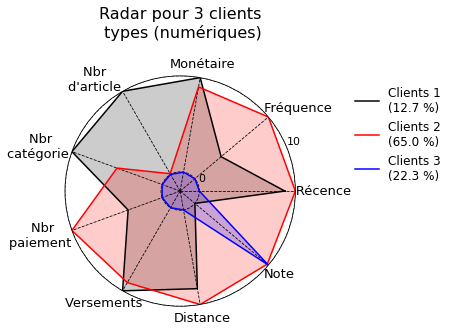

In [232]:
categories = ["       Récence", "         Fréquence", 'Monétaire', "Nbr          \nd'article          ", 
              "Nbr         \ncatégorie          ", 
              "Nbr        \npaiement         ", "Versements      ",
                  "Distance", "Note"]

client_1 = cluster_num_3.iloc[0,:].values.tolist()
client_2 = cluster_num_3.iloc[1,:].values.tolist()
client_3 = cluster_num_3.iloc[2,:].values.tolist()

client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])


liste_client = [client_1, client_2, client_3]
colors = ["black", "red", "blue", "green"]

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(4,4))
plt.subplot(polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_num_3[0]} %)", color = "black")
plt.fill(angles, client_1, "black", alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_num_3[1]} %)", color = "red")
plt.fill(angles, client_2, "red", alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_num_3[2]} %)", color = "blue")
plt.fill(angles, client_3, "blue", alpha=0.2)
    
    
lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)
plt.grid(visible=True, color="black", linestyle="dashed")
    
plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("Radar pour 3 clients\n types (numériques)", size=16, pad=20)
plt.legend(bbox_to_anchor=(1.21, 1),frameon=False, fontsize = 12)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)
plt.show()

<a class="anchor" id="section_2_4_3"></a>
### 2<sup>ème</sup> segmentation

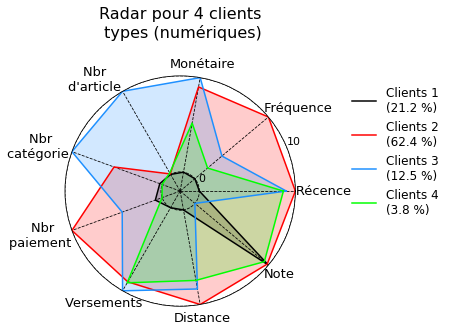

In [233]:
client_1 = cluster_num_4.iloc[0,:].values.tolist()
client_2 = cluster_num_4.iloc[1,:].values.tolist()
client_3 = cluster_num_4.iloc[2,:].values.tolist()
client_4 = cluster_num_4.iloc[3,:].values.tolist()

client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(4,4))
plt.subplot(polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_num_4[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_num_4[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_num_4[2]} %)", color="dodgerblue")
plt.fill(angles, client_3, "dodgerblue",alpha=0.2)

plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_num_4[3]} %)", color="lime")
plt.fill(angles, client_4, "lime",alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("Radar pour 4 clients\n types (numériques)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.2, 1),frameon=False, fontsize = 12)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

<a class="anchor" id="section_2_4_4"></a>
### 3<sup>ème</sup> segmentation

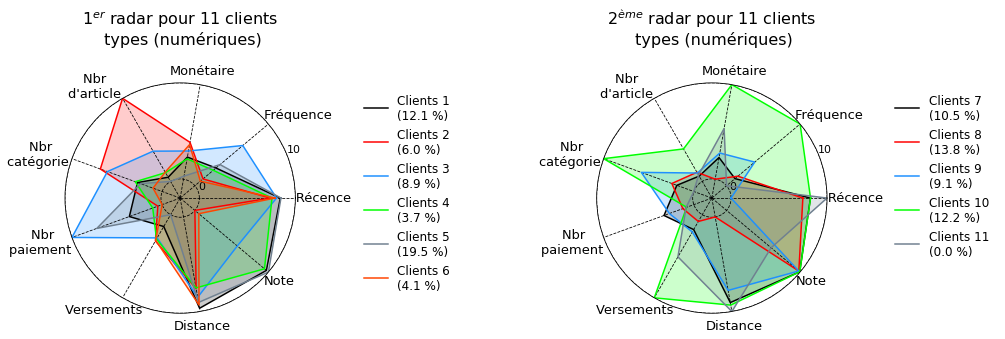

In [217]:
client_1 = cluster_num_11.iloc[0,:].values.tolist()
client_2 = cluster_num_11.iloc[1,:].values.tolist()
client_3 = cluster_num_11.iloc[2,:].values.tolist()
client_4 = cluster_num_11.iloc[3,:].values.tolist()
client_5 = cluster_num_11.iloc[4,:].values.tolist()
client_6 = cluster_num_11.iloc[5,:].values.tolist()
client_7 = cluster_num_11.iloc[6,:].values.tolist()
client_8 = cluster_num_11.iloc[7,:].values.tolist()
client_9 = cluster_num_11.iloc[8,:].values.tolist()
client_10 = cluster_num_11.iloc[9,:].values.tolist()
client_11 = cluster_num_11.iloc[10,:].values.tolist()


client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])
client_5.append(client_5[0])
client_6.append(client_6[0])
client_7.append(client_7[0])
client_8.append(client_8[0])
client_9.append(client_9[0])
client_10.append(client_10[0])
client_11.append(client_11[0])

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(15, 4))
plt.subplot(121, polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_num_11[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_num_11[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_num_11[2]} %)", color="dodgerblue")
plt.fill(angles, client_3, "dodgerblue",alpha=0.2)

plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_num_11[3]} %)", color="lime")
plt.fill(angles, client_4, "lime",alpha=0.2)

plt.plot(label_loc, client_5, label = f"Clients 5 \n({pourcentage_num_11[4]} %)", color="slategray")
plt.fill(angles, client_5, 'slategray', alpha=0.2)

plt.plot(label_loc, client_6, label = f"Clients 6 \n({pourcentage_num_11[5]} %)", color="orangered")
plt.fill(angles, client_6, "orangered",alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$1^{er}$ radar pour 11 clients\n types (numériques)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.25, 1),frameon=False, fontsize = 12)

plt.subplot(122, polar=True)

plt.plot(label_loc, client_7, label = f"Clients 7 \n({pourcentage_num_11[6]} %)", color="black")
plt.fill(angles, client_7, "black",alpha=0.2)

plt.plot(label_loc, client_8, label = f"Clients 8 \n({pourcentage_num_11[7]} %)", color="red")
plt.fill(angles, client_8, 'red', alpha=0.2)

plt.plot(label_loc, client_9, label = f"Clients 9 \n({pourcentage_num_11[8]} %)", color="dodgerblue")
plt.fill(angles, client_9, "dodgerblue",alpha=0.2)

plt.plot(label_loc, client_10, label = f"Clients 10 \n({pourcentage_num_11[9]} %)", color="lime")
plt.fill(angles, client_10, "lime",alpha=0.2)

plt.plot(label_loc, client_11, label = f"Clients 11 \n({pourcentage_num_11[10]} %)", color="slategray")
plt.fill(angles, client_11, 'slategray', alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)

plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$2^{ème}$ radar pour 11 clients\n types (numériques)", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.25, 1),frameon=False, fontsize = 12)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

Nous pouvons voir que pour les différents clusters choisis, il n'y a pas de segmentation visible sur l'ensemble des données numériques et par t-SNE. 

De plus, aucun client-type ne se dégage car nous ne savons pas ce qu'ils achétent concrétement et quand les clients achètent. 

C'est pourquoi nous allons poursuivre notre étude avec l'ensemble des données.
<a class="anchor" id="chapter3"></a>
# Chapitre 3 : Segmentation de l'ensemble des données
<a class="anchor" id="section_3_1"></a>
## K-means sur le jeu de données

In [152]:
inertia_olist = []
silhouettes_olist = []
davies_olist = []
calinski_olist = []
K_range_olist = range(2, 31)

for k in K_range_olist:
    model = KMeans(n_clusters=k, init = "k-means++").fit(X_olist_fit)
    inertia_olist.append(model.inertia_)
    
    silh = metrics.silhouette_score(X_olist_fit,model.labels_)
    silhouettes_olist.append(silh)
    
    dav = metrics.davies_bouldin_score(X_olist_fit,model.labels_)
    davies_olist.append(dav)
    
    cali = metrics.calinski_harabasz_score(X_olist_num_fit,model.labels_)
    calinski_olist.append(cali)
    
    if (k==5) | (k==15) | (k==25):
        print(k, round(silh,5), round(dav,5), round(cali,0))
    else:
        continue

5 0.132 2.23167 13963.0
15 0.08126 2.6804 5208.0
25 0.07719 2.62344 3294.0


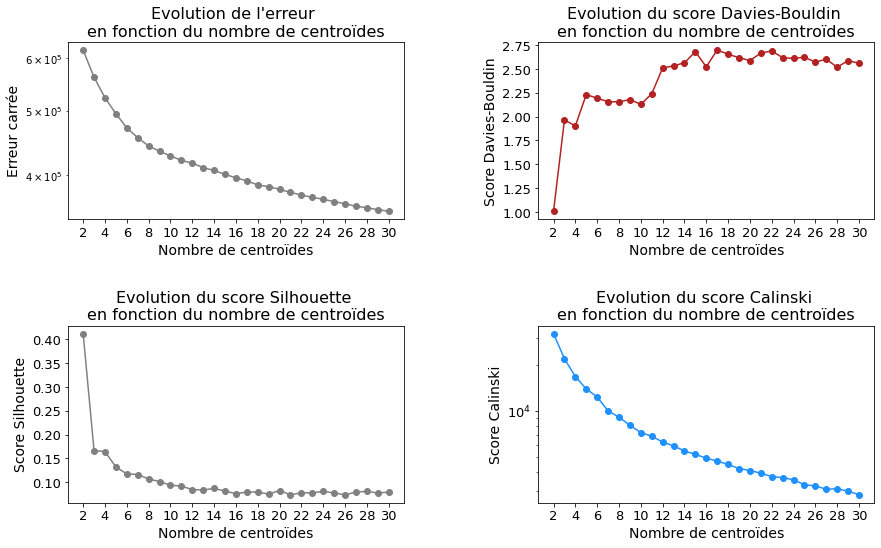

In [153]:
plt.figure(figsize=(14,8))

plt.subplot(221)
plt.plot(K_range_olist, inertia_olist, marker='o', color="gray")

plt.xticks(K_range_olist[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.yscale("log")

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Erreur carrée", fontsize = 14)

plt.title("Evolution de l'erreur \nen fonction du nombre de centroïdes", fontsize = 16)


plt.subplot(222)

plt.plot(K_range_olist, davies_olist, marker='o', color="firebrick")

plt.xticks(K_range_olist[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Davies-Bouldin", fontsize = 14)

plt.title("Evolution du score Davies-Bouldin \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(223)

plt.plot(K_range_olist, silhouettes_olist, marker='o', color="gray")

plt.xticks(K_range_olist[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Silhouette", fontsize = 14)

plt.title("Evolution du score Silhouette \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(224)

plt.plot(K_range_olist, calinski_olist, marker='o', color="dodgerblue")

plt.yscale("log")

plt.xticks(K_range_olist[::2], fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Calinski", fontsize = 14)

plt.title("Evolution du score Calinski \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
plt.show()

<a class="anchor" id="section_3_2"></a>
## Classification ascendante hierarchique

In [155]:
model_cat_100 = KMeans(n_clusters=100, init="k-means++")
model_cat_100.fit(X_olist_fit)

data_cluster_cat = model_cat_100.cluster_centers_

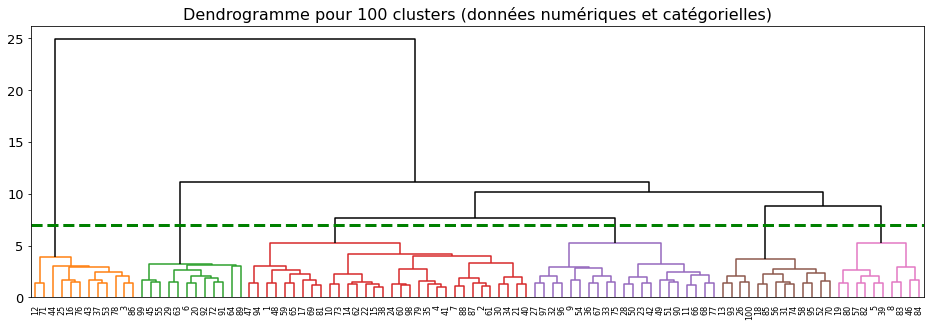

In [158]:
linkage_data_cat = linkage(data_cluster_cat, method='ward', metric='euclidean')
labels_str = [str(i) for i in np.arange(1,101,1)]

plt.figure(figsize=(16, 5))

dendrogram(linkage_data_cat, labels = labels_str, orientation = "top", color_threshold = 7, above_threshold_color = 'black')

plt.axhline(y = 7, ls="dashed", linewidth=3, c = "green")

plt.xticks(fontsize=8)
plt.yticks(fontsize=13)

plt.title("Dendrogramme pour 100 clusters (données numériques et catégorielles)", fontsize=16)

plt.show()

<a class="anchor" id="section_3_3"></a>
## Visualisation de la segmentation

En nous basant sur les scores, nous choisissons de segmenter les données en 4 clusters, 6 clusters et 7 clusters.

In [159]:
model_cat_4 = KMeans(n_clusters=4, init = "k-means++")
model_cat_4.fit(X_olist_fit)

model_cat_6 = KMeans(n_clusters=6, init = "k-means++")
model_cat_6.fit(X_olist_fit)

model_cat_7 = KMeans(n_clusters=7, init = "k-means++")
model_cat_7.fit(X_olist_fit)

KMeans(n_clusters=7)

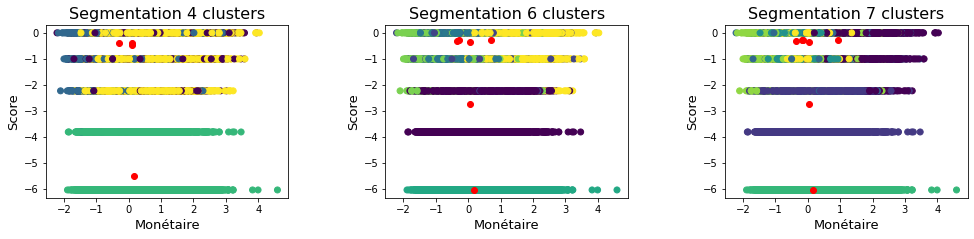

In [160]:
plt.figure(figsize=(16,3))
colonne_cat_simp = ['Récence', 'Fréquence', 'Monétaire', "Nbr d'articles", 'Nbr categorie',
                    'Nbr paiement', 'Nbr versement', 'Distance vendeur/client', 'Score', 
                    "Boleto", "Carte de crédit", "Carte débit", "Voucher", 
                    "Vêtements", "Electronique", "Nourriture", "Bien-être", "Maison"]

plt.subplot(1,3,1)
plt.scatter(X_olist_fit[:,2], X_olist_fit[:,8], c=model_cat_4.predict(X_olist_fit))
plt.scatter(model_cat_4.cluster_centers_[:,2], model_cat_4.cluster_centers_[:,8], color = "red")
    
plt.xlabel(f"{colonne_cat_simp[2]}", fontsize=13)
plt.ylabel(f"{colonne_cat_simp[8]}", fontsize=13)
    
plt.title("Segmentation 4 clusters", fontsize = 16)

plt.subplot(1,3,2)

plt.scatter(X_olist_fit[:,2], X_olist_fit[:,8], c=model_cat_6.predict(X_olist_fit))
plt.scatter(model_cat_6.cluster_centers_[:,2], model_cat_6.cluster_centers_[:,8], color = "red")
    
plt.xlabel(f"{colonne_cat_simp[2]}", fontsize=13)
plt.ylabel(f"{colonne_cat_simp[8]}", fontsize=13)
    
plt.title("Segmentation 6 clusters", fontsize = 16)
    
plt.subplot(1,3,3)

plt.scatter(X_olist_fit[:,2], X_olist_fit[:,8], c=model_cat_7.predict(X_olist_fit))
plt.scatter(model_cat_7.cluster_centers_[:,2], model_cat_7.cluster_centers_[:,8], color = "red")
    
plt.xlabel(f"{colonne_cat_simp[2]}", fontsize=13)
plt.ylabel(f"{colonne_cat_simp[8]}", fontsize=13)
    
plt.title("Segmentation 7 clusters", fontsize = 16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [6]:
X_categ_tsne = tsne.fit_transform(X_olist_fit)

C:\Users\farid\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


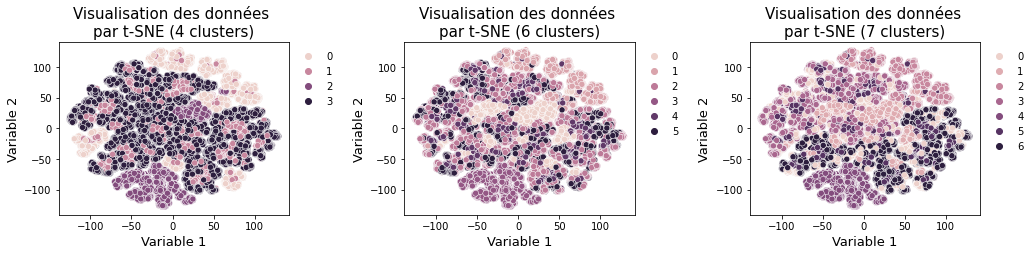

In [163]:
plt.figure(figsize=(16,3))
plt.subplot(131)
sns.scatterplot(x = X_categ_tsne[:,0], 
                y = X_categ_tsne[:,1],
                hue = model_cat_4.predict(X_olist_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données \npar t-SNE (4 clusters)", fontsize=15)


plt.legend(frameon = False, bbox_to_anchor=(1,1))
plt.subplot(132)
sns.scatterplot(x = X_categ_tsne[:,0], 
                y = X_categ_tsne[:,1],
                hue = model_cat_6.predict(X_olist_fit),
                legend = 'full')
plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données \npar t-SNE (6 clusters)", fontsize=15)

plt.legend(frameon = False, bbox_to_anchor=(1,1))
plt.subplot(133)
sns.scatterplot(x = X_categ_tsne[:,0], 
                y = X_categ_tsne[:,1],
                hue = model_cat_7.predict(X_olist_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données \npar t-SNE (7 clusters)", fontsize=15)

plt.legend(frameon = False, bbox_to_anchor=(1,1))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)
plt.show()

Nous pouvons voir que pour les différents clusters choisis, il n'y a pas de segmentation visible sur l'ensemble des données. 
Nous allons représenter les clients sous forme de radar.

En revanche, nous n'allons pas les représenter en fonction de l'ensemble des variables car il y en a trop (environ une trentaine). Nous allons utiliser l'ACP pour déterminer les variables les plus impactantes.

<a class="anchor" id="section_3_4"></a>
## Sélection des variables 

In [98]:
names = data_olist[col_categ].index
features = col_categ

n_components = 16
pca = PCA(n_components=n_components)
X_proj = pca.fit_transform(X_olist_fit)

x_list = range(1, n_components+1)
list(x_list)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

df_pca = pcs.T

df_pca["impact_var"] = np.abs(df_pca.iloc[:,:]).sum(axis=1)
df_pca["impact_var"] = df_pca["impact_var"]*100/(df_pca["impact_var"].sum(axis=0))
df_pca = df_pca.sort_values("impact_var", ascending=False)

df_best_pca = df_pca.iloc[:12,:]
df_best_pca.shape

(12, 17)

In [99]:
df_best_pca = df_best_pca.sort_values("impact_var", ascending=True)
display(df_best_pca.index)

Index(['review_score', 'main_category_Sport_leisure',
       'main_category_Electronics', 'mois_commande_2nd_quarter',
       'distance_seller_customer', 'main_category_House',
       'type_payment_credit_card', 'recency', 'payment_installments',
       'monetary', 'mois_commande_1st_quarter', 'mois_commande_3rd_quarter'],
      dtype='object')

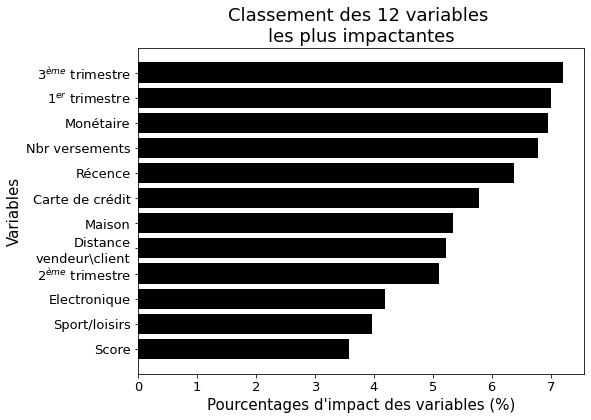

In [101]:
index_simpl = ["Score", "Sport/loisirs", "Electronique", "$2^{ème}$ trimestre", "Distance\nvendeur\client",  "Maison", 
               "Carte de crédit","Récence", "Nbr versements", "Monétaire", "$1^{er}$ trimestre", "$3^{ème}$ trimestre"
               ]

plt.figure(figsize=(8,6))

plt.barh(width = df_best_pca.iloc[:,-1], y = index_simpl, color="black")

plt.xlabel("Pourcentages d'impact des variables (%)", fontsize=15)
plt.ylabel("Variables", fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("Classement des 12 variables \nles plus impactantes", fontsize=18)
plt.show()

Nous venons de sélectionner les variables les plus impactantes grâce à l'ACP. Nous allons représenter les clients avec des radars.

<a class="anchor" id="section_3_5"></a>
## Représentation des clients types

Comme précedemment, nous allons représenter chaque client via un radar et essayer d'identifier des client types.

<a class="anchor" id="section_3_5_1"></a>
### Préparation des radars

La procédure reste identique à précédemment. 

In [180]:
data_olist["cluster_categ_4"] = pd.Series(model_cat_4.labels_)
data_olist["cluster_categ_6"] = pd.Series(model_cat_6.labels_)
data_olist["cluster_categ_7"] = pd.Series(model_cat_7.labels_)

pourcentage_categ_4 = ((data_olist["cluster_categ_4"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_categ_6 = ((data_olist["cluster_categ_6"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_categ_7 = ((data_olist["cluster_categ_7"].value_counts(normalize=True).sort_index())*100).round(1)

In [219]:
col_categ_4 = ['recency', 'monetary', 'payment_installments', 'distance_seller_customer', 'review_score', 
               'type_payment_credit_card', 'main_category_House', 'main_category_Sport_leisure', 'main_category_Electronics', 
               'mois_commande_1st_quarter', 'mois_commande_2nd_quarter', 'mois_commande_3rd_quarter',
               "cluster_categ_4"]

col_categ_6 = ['recency', 'monetary', 'payment_installments', 'distance_seller_customer', 'review_score', 
               'type_payment_credit_card', 'main_category_House', 'main_category_Sport_leisure', 'main_category_Electronics', 
               'mois_commande_1st_quarter', 'mois_commande_2nd_quarter', 'mois_commande_3rd_quarter',
               "cluster_categ_6"]

col_categ_7 = ['recency', 'monetary', 'payment_installments', 'distance_seller_customer', 'review_score', 
               'type_payment_credit_card', 'main_category_House', 'main_category_Sport_leisure', 'main_category_Electronics', 
               'mois_commande_1st_quarter', 'mois_commande_2nd_quarter', 'mois_commande_3rd_quarter',
                "cluster_categ_7"
                ]

col_categ_simple = ["Recency", 'Monetary', "Installments", "Distance", "Score", "Credit\ncard", "House", "Sport\nleisure", 
                    "Electronics", "$1^{st}$ quarter", "$2^{nd}$ quarter", "$3^{rd}$ quarter"]

In [220]:
cluster_categ_client_4 = data_olist[col_categ_4].groupby("cluster_categ_4").mean()
cluster_categ_client_6 = data_olist[col_categ_6].groupby("cluster_categ_6").mean()
cluster_categ_client_7 = data_olist[col_categ_7].groupby("cluster_categ_7").mean()

In [221]:
scaler = MinMaxScaler(feature_range=(0, 10))

cluster_categ_4 = pd.DataFrame(scaler.fit_transform(cluster_categ_client_4), 
                         columns = cluster_categ_client_4.columns)

cluster_categ_6 = pd.DataFrame(scaler.fit_transform(cluster_categ_client_6), 
                         columns = cluster_categ_client_6.columns)

cluster_categ_7 = pd.DataFrame(scaler.fit_transform(cluster_categ_client_7), 
                         columns = cluster_categ_client_7.columns)

<a class="anchor" id="section_3_5_2"></a>
### 1<sup>ère</sup> segmentation

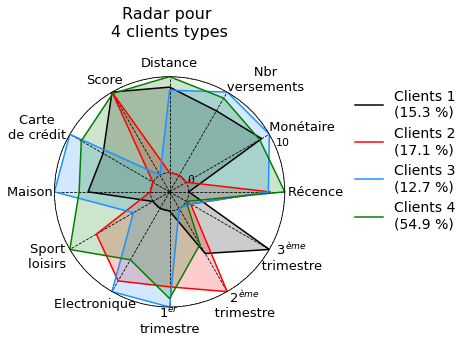

In [224]:
categories = ["        Récence", "          Monétaire", "               Nbr\n               versements", "Distance", "Score", 
              "Carte          \nde crédit          ", "Maison     ", "Sport     \nloisirs     ", "Electronique     ", 
              "$1^{er}$\ntrimestre", "     $2^{ème}$\n     trimestre", "     $3^{ème}$\n     trimestre"]

client_1 = cluster_categ_4.iloc[0,:].values.tolist()
client_2 = cluster_categ_4.iloc[1,:].values.tolist()
client_3 = cluster_categ_4.iloc[2,:].values.tolist()
client_4 = cluster_categ_4.iloc[3,:].values.tolist()


client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(4,4))
plt.subplot(polar=True)


plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_categ_4[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_categ_4[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_categ_4[2]} %)", color="dodgerblue")
plt.fill(angles, client_3, "dodgerblue",alpha=0.2)

plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_categ_4[3]} %)", color="green")
plt.fill(angles, client_4, "green",alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("Radar pour \n4 clients types", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.25, 1),frameon=False, fontsize = 14)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

<a class="anchor" id="section_3_5_3"></a>
### 2<sup>ème</sup> segmentation

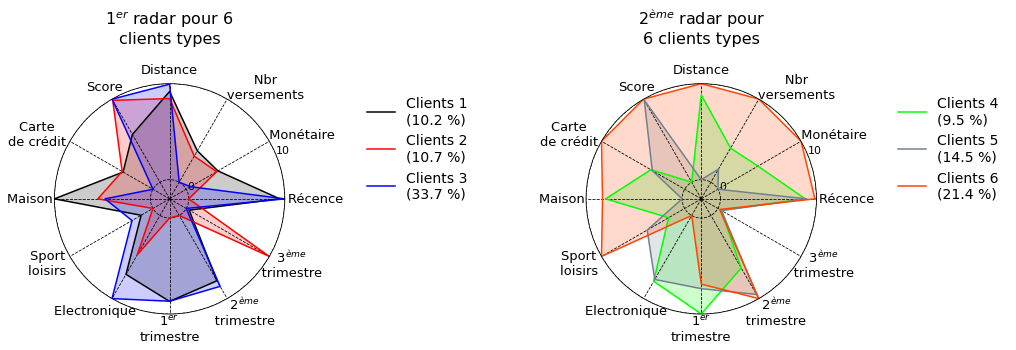

In [225]:
client_1 = cluster_categ_6.iloc[0,:].values.tolist()
client_2 = cluster_categ_6.iloc[1,:].values.tolist()
client_3 = cluster_categ_6.iloc[2,:].values.tolist()
client_4 = cluster_categ_6.iloc[3,:].values.tolist()
client_5 = cluster_categ_6.iloc[4,:].values.tolist()
client_6 = cluster_categ_6.iloc[5,:].values.tolist()

client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])
client_5.append(client_5[0])
client_6.append(client_6[0])

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(15, 4))
plt.subplot(121, polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_categ_6[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_categ_6[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_categ_6[2]} %)", color="blue")
plt.fill(angles, client_3, "blue",alpha=0.2)


lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$1^{er}$ radar pour 6 \nclients types", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 14)

plt.subplot(122, polar=True)

plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_categ_6[3]} %)", color="lime")
plt.fill(angles, client_4, "lime",alpha=0.2)

plt.plot(label_loc, client_5, label = f"Clients 5 \n({pourcentage_categ_6[4]} %)", color="slategray")
plt.fill(angles, client_5, 'slategray', alpha=0.2)

plt.plot(label_loc, client_6, label = f"Clients 6 \n({pourcentage_categ_6[5]} %)", color="orangered")
plt.fill(angles, client_6, "orangered",alpha=0.2)


lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)

plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$2^{ème}$ radar pour \n6 clients types", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 14)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

<a class="anchor" id="section_3_5_4"></a>
### 3<sup>ème</sup> segmentation

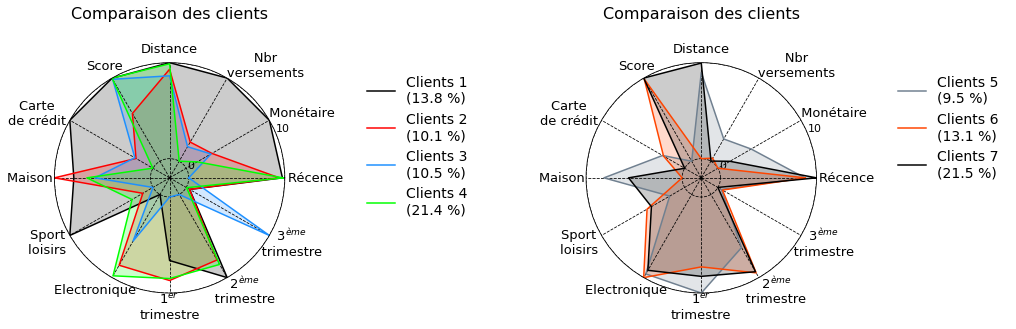

In [186]:
client_1 = cluster_categ_7.iloc[0,:].values.tolist()
client_2 = cluster_categ_7.iloc[1,:].values.tolist()
client_3 = cluster_categ_7.iloc[2,:].values.tolist()
client_4 = cluster_categ_7.iloc[3,:].values.tolist()
client_5 = cluster_categ_7.iloc[4,:].values.tolist()
client_6 = cluster_categ_7.iloc[5,:].values.tolist()
client_7 = cluster_categ_7.iloc[6,:].values.tolist()


client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])
client_5.append(client_5[0])
client_6.append(client_6[0])
client_7.append(client_7[0])

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(15, 4))
plt.subplot(121, polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_categ_7[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_categ_7[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_categ_7[2]} %)", color="dodgerblue")
plt.fill(angles, client_3, "dodgerblue",alpha=0.2)

plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_categ_7[3]} %)", color="lime")
plt.fill(angles, client_4, "lime",alpha=0.2)


lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("Comparaison des clients\n", size=16)

plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 14)

plt.subplot(122, polar=True)

plt.plot(label_loc, client_5, label = f"Clients 5 \n({pourcentage_categ_7[4]} %)", color="slategray")
plt.fill(angles, client_5, 'slategray', alpha=0.2)

plt.plot(label_loc, client_6, label = f"Clients 6 \n({pourcentage_categ_7[5]} %)", color="orangered")
plt.fill(angles, client_6, "orangered",alpha=0.2)

plt.plot(label_loc, client_7, label = f"Clients 7 \n({pourcentage_categ_7[6]} %)", color="black")
plt.fill(angles, client_7, "black",alpha=0.2)

lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)

plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("Comparaison des clients\n", size=16)

plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 14)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

Les variables ayant le plus d'impact sur le jeu de données ne permettent pas d'identifier des clients. 

C'est pourquoi nous allons reprendre la même étude mais en utilisant des variables permettant d'établir des profils type de clients.

Nous allons considérer les variables suivantes :
- somme dépensée (monétaire),
- le nombre de produits achetées,
- la ou les catégories d'articles achetés (Maison, Electronique, Sport/loisirs, Soin/beauté),
- le nombre de catégorie d'articles achetés,
- les heures d'achats (heures ouvrées ou non),
- période d'achat (vacances ou période scolaire) et
- la satisfaction des clients (score attribuée).